# LEAP Plotting in Jupyter

Easy access to visualization makes for a smooth algorithm development cycle.  LEAP offers components to assist with plotting algorithms and problems with `matplotlib` and Jupyter.

## Live BSF Curves

In the [simple_ea.py](simple_ea.py) example, we used the `simple_ea(...)` function to apply some classic EAs to the Spheroid function.

We gave our application a handy CLI wrapper:

In [1]:
%run simple_ea.py mu-comma-lambda --help

Usage: simple_ea.py mu-comma-lambda [OPTIONS]

  Apply a (μ, λ)-style generational EA with tournament selection and
  Gaussian mutation to the `Spheroid` function.

Options:
  --evals INTEGER      Fitness evaluations to run for
  --pop_size INTEGER   Population size
  --l INTEGER          Length of the genome
  --mutate-prob FLOAT  Per-gene Gaussian mutation rate
  --mutate-std FLOAT   Standard deviation of Gaussian mutation
  --help               Show this message and exit.


And it prints out pretty numbers to `stdout`:

In [1]:
%run simple_ea.py mu-comma-lambda

generation, best_of_gen_fitness
5, 71.7261335868346
10, 71.7261335868346
15, 71.7672582408357
20, 71.75872544446695
25, 71.75872544446695
30, 71.48011334626139
35, 71.43110396158744
40, 71.44135354302686
45, 71.46279510587155
50, 71.42756024362818
55, 71.161798449104
60, 71.23903276546015
65, 70.95375711965576
70, 70.95375711965576
75, 70.59883132913006
80, 70.14230228013331
85, 69.58380696341119
90, 69.68933244196012
95, 69.4405021429254
100, 69.2140251175479


But we can do better.  By simply inserting a `probe.PlotProbe` object into our EA operator pipeline, we can watch a fitness curve as it evolves in **real time**.

The key to live animation is to use the `%matplotlib notebook` magic:

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

Next we'll create the probe operator.  The probe will automatically scale the axes to ensure that the entire curve stays within view, but you optionally can set `xlim` and `ylim` bounds to add more space:

<IPython.core.display.Javascript object>


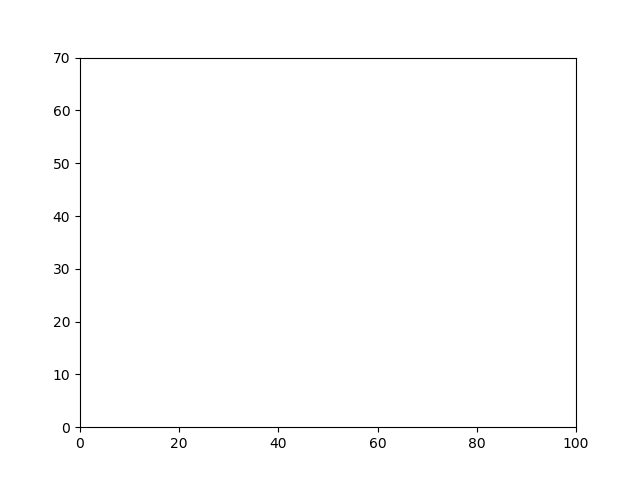

In [3]:
from leap.probe import PlotProbe

plt.figure()  # Setup a figure to plot to
plot_probe = PlotProbe(ylim=(0, 70), ax=plt.gca())

Not much is happening yet.  We've created the probe and attached it to a figure—but it still needs an algorithm!

Here we build a classic (μ, λ)-style EA to solve the `Spheroid` function—but we insert hooks from our `PlotProbe` in **two places**:

 1. The **step notification** list: this tells the algorithm that it needs to call `plot_probe.set_step` at each generation boundary to update the plot's x-coordinate
 
 ```Python
 step_notify_list=[plot_probe.set_step], 
 ```
 
 2. The **operator pipeline**: this ensures that the population passes through the probe at each iteration, so data can be collected for the y-coordinate
 
 ```Python
 pipeline=[
           plot_probe,
           ...
       ]
 ```

In [4]:
from leap.example.simple_ea import simple_ea
from leap import core, real, operate as op

evals=1000
pop_size=5
l=10
mutate_prob=1/l
mutate_std=1.0

ea = simple_ea(evals=evals, pop_size=pop_size,
               individual_cls=core.Individual,
               decoder=core.IdentityDecoder(),
               problem=real.Spheroid(maximize=False),
               evaluate=op.evaluate,

               initialize=real.create_real_value_sequence(
                   bounds=[[-5.12, 5.12]] * l
               ),
            
               step_notify_list=[plot_probe.set_step], # STEP NOTIFICATION: sets plot_probe's x-coordinate
               
               pipeline=[
                   # PIPELINE: sets plot_probe's y-coordinate
                   plot_probe,
                   op.tournament(n=pop_size),
                   op.cloning,
                   op.mutate_gaussian(prob=mutate_prob, std=mutate_std)
               ])
list(ea);

ModuleNotFoundError: No module named 'leap.example'

Scroll up to the previous cell while the algorithm is running—the live results get placed there, thanks to the callbacks on `plot_probe`!

## Viewing Fitness Functions

<IPython.core.display.Javascript object>


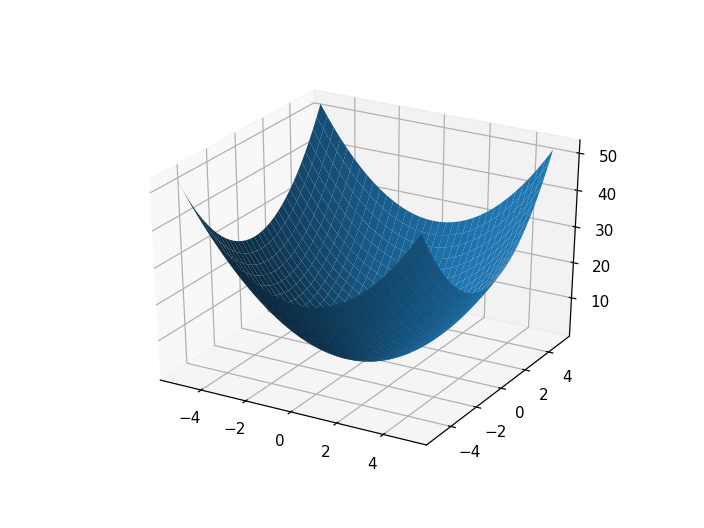

In [6]:
%matplotlib notebook
from leap import real
from mpl_toolkits.mplot3d import Axes3D

real.plot_2d_problem(real.Spheroid(), xlim=(-5.12, 5.12), ylim=(-5.12, 5.12));

## Viewing Population Trajectories



<IPython.core.display.Javascript object>


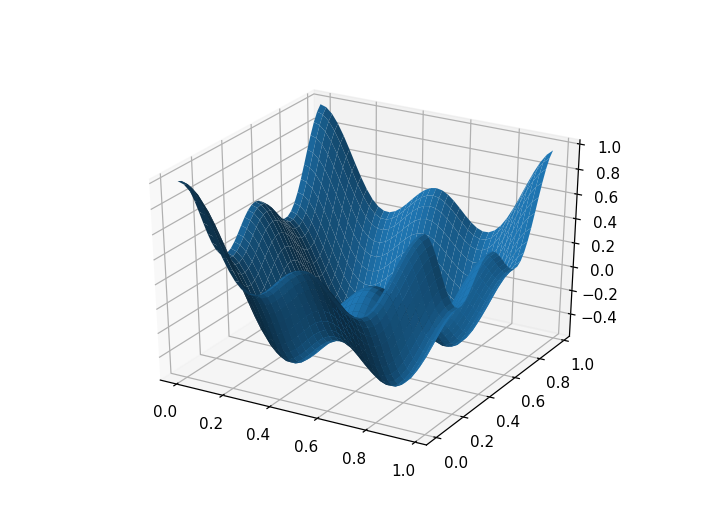

In [7]:
problem = real.CosineFamilyProblem(alpha=1.0, global_optima_counts=[2, 2], local_optima_counts=[2, 2])
real.plot_2d_problem(problem, xlim=(0, 1), ylim=(0, 1), granularity=0.025);

<IPython.core.display.Javascript object>


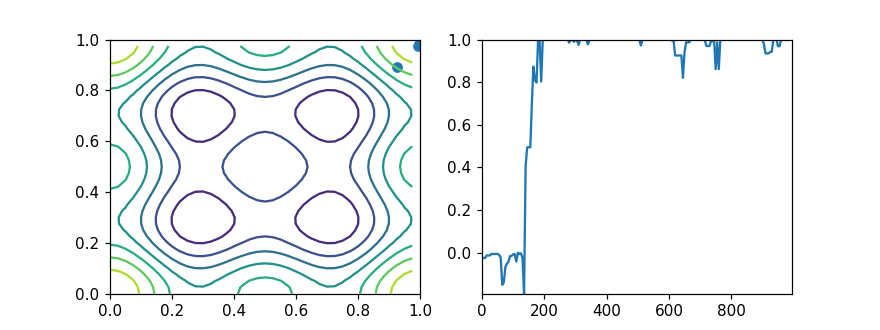

In [8]:
from leap.probe import PlotTrajectoryProbe

plt.figure(figsize=(8, 3))  # Setup a figure to plot to
plt.subplot(121)
trajectory_probe = PlotTrajectoryProbe(contours=problem, ax=plt.gca(), xlim=(0, 1), ylim=(0, 1), granularity=0.025)
plt.subplot(122)
fitness_probe = PlotProbe(ylim=(0, 1), ax=plt.gca())

In [9]:
from leap.example.simple_ea import simple_ea
from leap import core, real, operate as op

evals=1000
pop_size=5
l=2
mutate_prob=1/l
mutate_std=0.1

ea = simple_ea(evals=evals, pop_size=pop_size,
               individual_cls=core.Individual,  # Use the standard Individual as the prototype for the population.
               decoder=core.IdentityDecoder(),  # Genotype and phenotype are the same for this task.
               problem=problem,  # Solve a Spheroid minimization problem.
               evaluate=op.evaluate,  # Evaluate fitness with the basic evaluation operator.

               # Initialized genomes are random real-valued vectors.
               initialize=real.create_real_value_sequence(
                   # Initialize each element between 0 and 1.
                   bounds=[[0.4, 0.6]] * l
               ),
               
               step_notify_list=[fitness_probe.set_step], # We only need step notification for the fitness curve probe
               
               pipeline=[
                   # Place both probes in the pipeline
                   trajectory_probe,
                   fitness_probe,
                   op.tournament(n=pop_size),
                   # Clone them to create offspring.
                   op.cloning,
                   # Apply Gaussian mutation to each gene with a certain probability.
                   op.mutate_gaussian(prob=mutate_prob, std=mutate_std, hard_bounds=(0, 1))
               ])
list(ea);